# DPS Classic AI Challenge

## Data Loading

In [176]:
import pandas as pd

# Load the dataset
data = pd.read_csv('MV_Stats.csv')

# Keep only the first five columns
data = data.iloc[:, :5]

# Rename columns for better understanding
data.rename(columns={
    'MONATSZAHL': 'Category',
    'AUSPRAEGUNG': 'Accident-Type',
    'JAHR': 'Year',
    'MONAT': 'Month',
    'WERT': 'Value'
}, inplace=True)

# Display the first few rows of the filtered dataset
print(data.head())

         Category Accident-Type  Year   Month  Value
0  Alkoholunfälle     insgesamt  2024  202401    NaN
1  Alkoholunfälle     insgesamt  2024  202402    NaN
2  Alkoholunfälle     insgesamt  2024  202403    NaN
3  Alkoholunfälle     insgesamt  2024  202404    NaN
4  Alkoholunfälle     insgesamt  2024  202405    NaN


In [177]:
# Check for duplicate rows based on the first four columns
duplicates = data.duplicated(subset=data.columns[:4])

# Print if duplicates exist
if duplicates.any():
    print("Duplicate rows found:")
    print(data[duplicates])
else:
    print("No duplicate rows found.")

No duplicate rows found.


In [178]:
# Identify columns with missing values
missing_columns = data.columns[data.isnull().any()].tolist()
print("Columns with missing values:", missing_columns)

Columns with missing values: ['Value']


In [179]:
# Find rows with missing values and get their 'Year' values
missing_rows = data[data.isnull().any(axis=1)]
missing_years = missing_rows['Year'].unique()
print("Unique Year values with missing data:", missing_years)

Unique Year values with missing data: [2024 2023]


In [180]:
# Filter rows where 'Year' is 2023 or 2024 and 'Value' is not null
filtered_rows = data[(data['Year'].isin([2023, 2024])) & (data['Value'].notnull())]

# Print the result
if filtered_rows.empty:
    print("No rows found where Year is 2023 or 2024 and Value is not null.")
else:
    print("There are rows where Year is 2023 or 2024 and Value is not null.")    

No rows found where Year is 2023 or 2024 and Value is not null.


The values for the last two years has not yet been entered, but all the data before that is complete.

We remove rows where Value is missing, and also those where Month is 'Summe'.

In [181]:
# Drop rows with missing values
data = data.dropna()

# Remove rows where 'Month' is 'Summe'
data = data[data['Month'] != 'Summe']

In [182]:
# Get the unique combinations of 'Category' and 'Accident-Type'
unique_combinations = data[['Category', 'Accident-Type']].drop_duplicates()

# Count the number of unique combinations
num_combinations = unique_combinations.shape[0]

# Display the result
print(f"Total number of unique Category and Accident-Type combinations: {num_combinations}")

# Display the combinations
print(unique_combinations)

Total number of unique Category and Accident-Type combinations: 7
             Category           Accident-Type
25     Alkoholunfälle               insgesamt
347    Alkoholunfälle  Verletzte und Getötete
669     Fluchtunfälle               insgesamt
991     Fluchtunfälle  Verletzte und Getötete
1313  Verkehrsunfälle               insgesamt
1635  Verkehrsunfälle     mit Personenschäden
1957  Verkehrsunfälle  Verletzte und Getötete


In [183]:
# Initialize a list to store results
results = []

# Loop through each combination
for _, row in unique_combinations.iterrows():
    category = row['Category']
    accident_type = row['Accident-Type']

    # Filter data for the current combination
    subset = data[(data['Category'] == category) & (data['Accident-Type'] == accident_type)]

    # Get unique years and check continuity
    unique_years = sorted(subset['Year'].unique())
    total_years = len(unique_years)
    min_year = min(unique_years) if unique_years else None
    max_year = max(unique_years) if unique_years else None
    is_consecutive = (max_year - min_year + 1) == total_years if unique_years else False

    # Count months per year
    month_counts = subset.groupby('Year')['Month'].nunique()
    incomplete_years = month_counts[month_counts != 12]

    # Append results
    results.append({
        'Category': category,
        'Accident-Type': accident_type,
        'Min': min_year,
        'Max': max_year,
        'Consecutive': is_consecutive,
        'Incomplete': ', '.join(map(str, incomplete_years.index.tolist())) \
            if not incomplete_years.empty else None
    })

# Convert results to a DataFrame for easy display
results_df = pd.DataFrame(results)
print(results_df)

          Category           Accident-Type   Min   Max  Consecutive Incomplete
0   Alkoholunfälle               insgesamt  2000  2022         True       None
1   Alkoholunfälle  Verletzte und Getötete  2000  2022         True       None
2    Fluchtunfälle               insgesamt  2000  2022         True       None
3    Fluchtunfälle  Verletzte und Getötete  2000  2022         True       None
4  Verkehrsunfälle               insgesamt  2000  2022         True       None
5  Verkehrsunfälle     mit Personenschäden  2000  2022         True       None
6  Verkehrsunfälle  Verletzte und Getötete  2000  2022         True       None


The data for each month during these years is complete and without any gaps.

Since we are only concerned with the Category in this task, we filter the data to retain rows where Accident-Type is 'insgesamt' and then drop the Accident-Type column as it is no longer relevant. We also reformat the Month column.

In [184]:
# Filter rows where 'Accident-type' is 'insgesamt'
filtered_data = data[data['Accident-Type'] == 'insgesamt']

# Drop the 'Accident-type' column
filtered_data = filtered_data.drop(columns=['Accident-Type'])

# Extract only the month part from the 'Month' column
# Assuming the format is like '202010', we extract the last two digits
filtered_data['Month'] = filtered_data['Month'].astype(str).str[-2:].astype(int)

# Ensure 'Date' column is created for proper time-based plotting
filtered_data.loc[:, 'Date'] = pd.to_datetime(filtered_data['Year'].astype(str) \
    + '-' + filtered_data['Month'].astype(str) + '-01')

# Display the updated DataFrame
print(filtered_data.head())

          Category  Year  Month  Value       Date
25  Alkoholunfälle  2022      1   19.0 2022-01-01
26  Alkoholunfälle  2022      2   32.0 2022-02-01
27  Alkoholunfälle  2022      3   28.0 2022-03-01
28  Alkoholunfälle  2022      4   34.0 2022-04-01
29  Alkoholunfälle  2022      5   57.0 2022-05-01


Data from 2020 and earlier will be used for training the model, while data from 2021 onwards will be reserved for testing.

In [185]:
# Split the data into training and testing sets
train_data = filtered_data[filtered_data['Year'] <= 2020]
test_data = filtered_data[filtered_data['Year'] > 2020]

# Display the split datasets
print("Training data (2020 and earlier):")
print(train_data.head())

print("\nTest data (2021 and later):")
print(test_data.head())

Training data (2020 and earlier):
          Category  Year  Month  Value       Date
51  Alkoholunfälle  2020      1   28.0 2020-01-01
52  Alkoholunfälle  2020      2   40.0 2020-02-01
53  Alkoholunfälle  2020      3   27.0 2020-03-01
54  Alkoholunfälle  2020      4   26.0 2020-04-01
55  Alkoholunfälle  2020      5   40.0 2020-05-01

Test data (2021 and later):
          Category  Year  Month  Value       Date
25  Alkoholunfälle  2022      1   19.0 2022-01-01
26  Alkoholunfälle  2022      2   32.0 2022-02-01
27  Alkoholunfälle  2022      3   28.0 2022-03-01
28  Alkoholunfälle  2022      4   34.0 2022-04-01
29  Alkoholunfälle  2022      5   57.0 2022-05-01


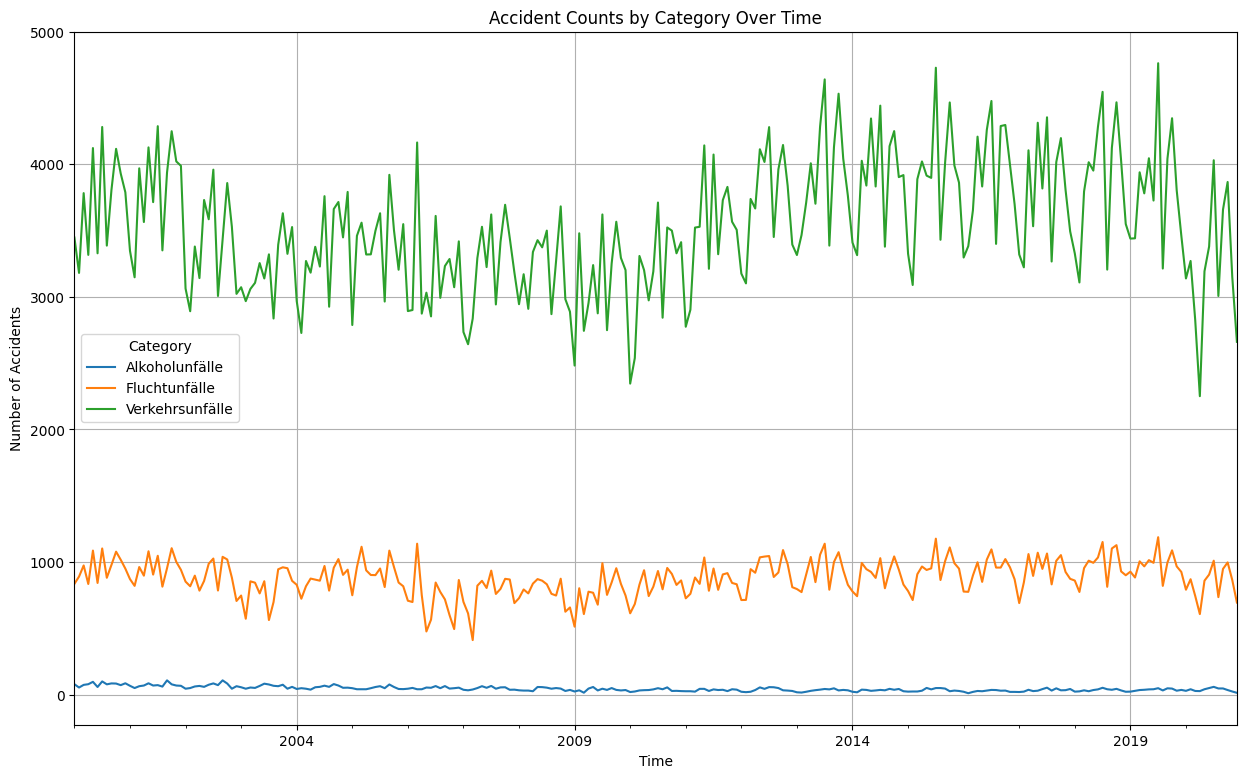

In [186]:
import matplotlib.pyplot as plt

# Pivot the data to have categories as columns
pivot_data = train_data.pivot_table(index='Date', columns='Category', values='Value', aggfunc='sum')

# Plot the line chart
plt.figure(figsize=(15, 9))
pivot_data.plot(ax=plt.gca())

# Chart formatting
plt.title('Accident Counts by Category Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Accidents')
plt.legend(title='Category')
plt.grid(True)

# Show the plot
plt.show()

The chart shows that Alkoholunfälle (alcohol-related accidents) has the lowest volume and smallest fluctuations compared to Verkehrsunfälle (general traffic accidents) and Fluchtunfälle (hit-and-run accidents). The large magnitude difference between categories may require normalization to balance their influence if we are to include them all as features in the model.

## Baseline Time Series

Train size: 201
Validation size: 51
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=1460.649, Time=2.89 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1611.170, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1533.628, Time=0.24 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1524.406, Time=0.64 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1609.236, Time=0.18 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=inf, Time=2.20 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=1482.855, Time=1.62 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=1456.144, Time=4.85 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=1468.751, Time=5.06 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=1466.062, Time=5.79 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=1463.086, Time=5.02 sec
 ARIMA(1,1,2)(2,0,1)[12] intercept   : AIC=1453.951, Time=4.06 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=1451.962, Time=1.87 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=1509.352, Ti

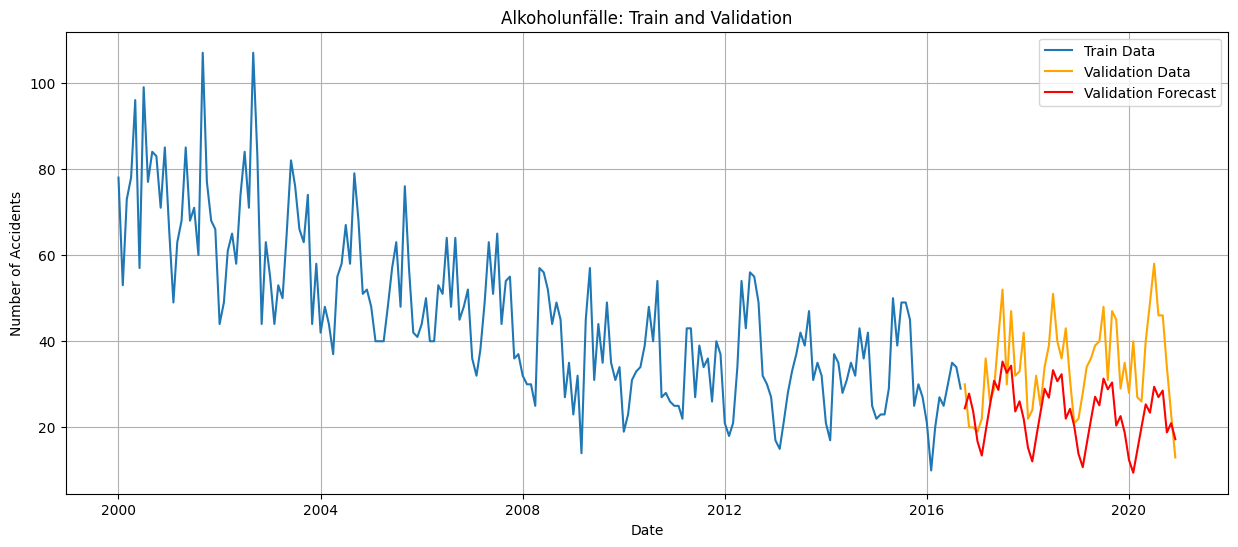

In [187]:
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima

# Filter for Category 'Alkoholunfälle'
alkohol_data = train_data[train_data['Category'] == 'Alkoholunfälle'].copy()
alkohol_data.set_index('Date', inplace=True)
alkohol_data = alkohol_data.sort_index()

# Select only the 'Value' column
time_series = alkohol_data['Value']

# Split the data into train and validation sets (80% for training, 20% for validation)
train_ratio = 0.8
n = len(time_series)
train_end = int(n * train_ratio)

train = time_series.iloc[:train_end]
validation = time_series.iloc[train_end:]

# Print the sizes of each set
print(f"Train size: {len(train)}")
print(f"Validation size: {len(validation)}")

# Train SARIMA model
model = auto_arima(
    train,
    seasonal=True,
    m=12,
    trace=True,
    stepwise=True,
    suppress_warnings=True
)

# Validate on validation data
forecast_steps = len(validation)
validation_forecast = model.predict(n_periods=forecast_steps)

# Align forecast index with validation index
validation_forecast = pd.Series(validation_forecast, index=validation.index)

# Calculate Mean Squared Error
validation_error = mean_squared_error(validation, validation_forecast)
print(f"Validation Mean Squared Error: {validation_error:.2f}")

# Plot the results
plt.figure(figsize=(15, 6))
plt.plot(train, label='Train Data')
plt.plot(validation, label='Validation Data', color='orange')
plt.plot(validation.index, validation_forecast, label='Validation Forecast', color='red')
plt.title('Alkoholunfälle: Train and Validation')
plt.xlabel('Date')
plt.ylabel('Number of Accidents')
plt.legend()
plt.grid(True)
plt.show()

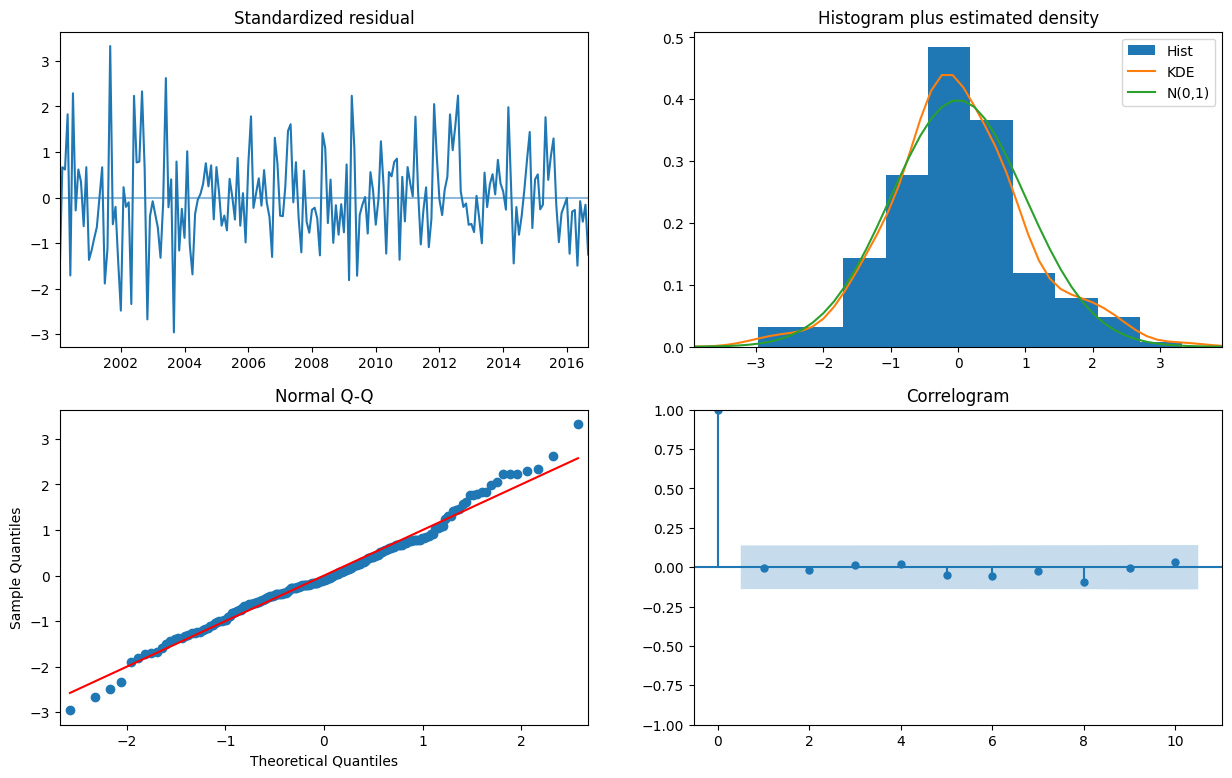

In [188]:
# Plot diagnostic graphs for the SARIMA model
model.plot_diagnostics(figsize=(15, 9))
plt.show()

The residuals are approximately normally distributed and mostly uncorrelated, indicating that the SARIMA model has captured the main patterns in the data. A slight autocorrelation at lag 1 suggests some short-term dependencies remain unexplained.

The red line (Validation Forecast) follows the overall downward trend established by the blue line (Train Data). However, the orange line (Validation Data) shows a rebound or increase in the validation period, which the model fails to capture. This discrepancy suggests that the model does not adequately account for more recent dynamics or short-term variability.

## Vector Autoregression

Optimal lag order: 12
Validation MSE for each category:
Alkoholunfälle		136.54035639968197
Fluchtunfälle		15682.987953481606
Verkehrsunfälle		508044.41655104025


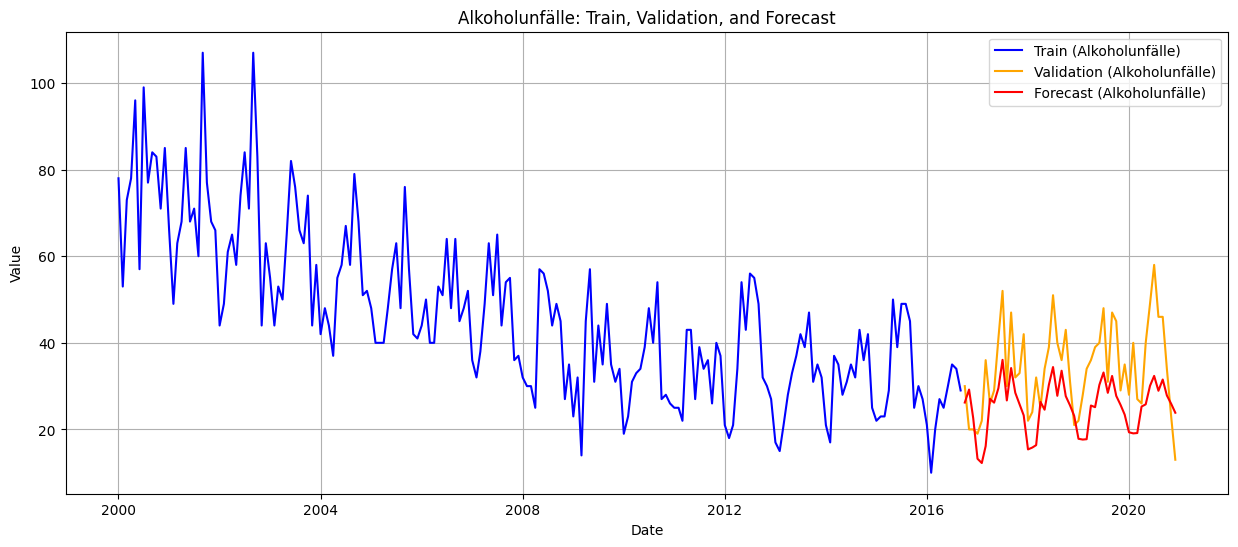

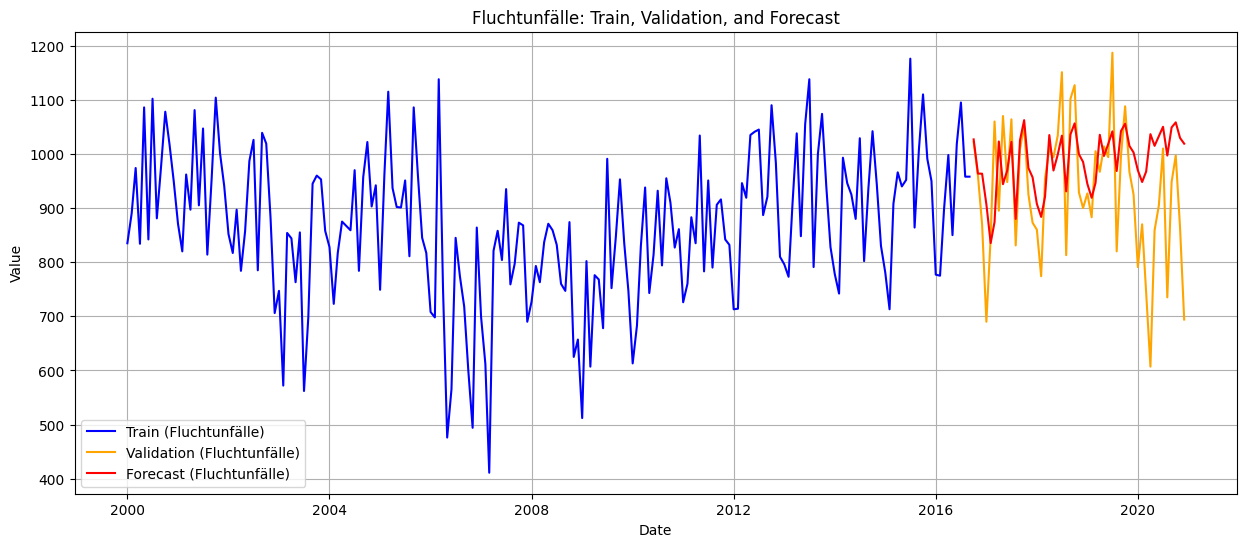

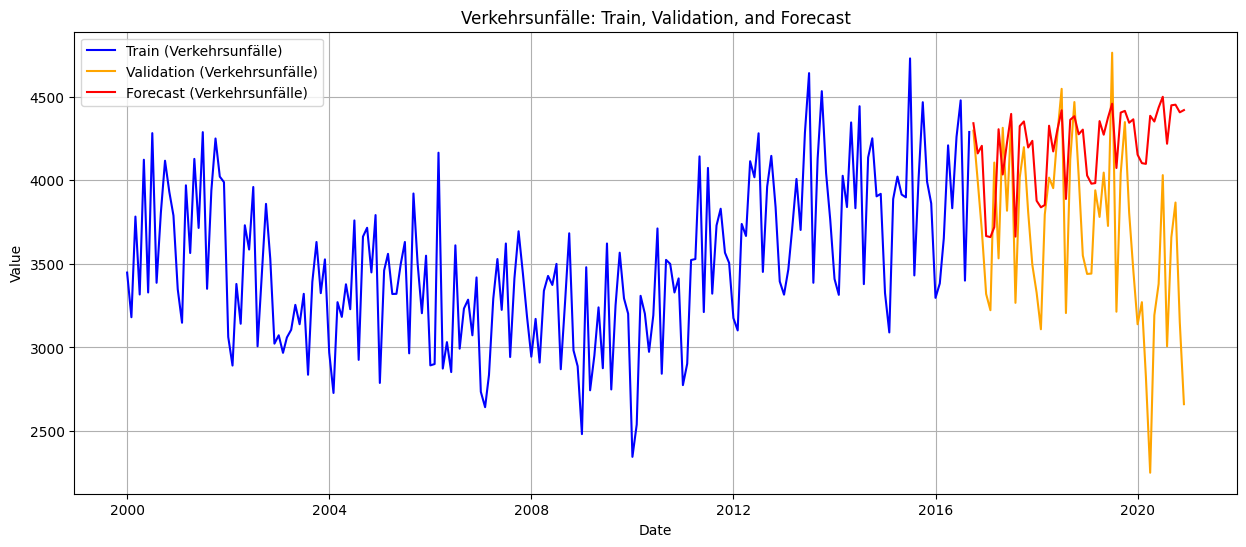

In [189]:
from statsmodels.tsa.api import VAR

# Prepare data for VAR (pivot to wide format with categories as columns)
wide_data = train_data.pivot(index='Date', columns='Category', values='Value')

# Set frequency explicitly
wide_data = wide_data.asfreq('MS')

# Train-Validation Split (80% train, 20% validation)
train_size = int(len(wide_data) * 0.8)
train = wide_data.iloc[:train_size]
validation = wide_data.iloc[train_size:]

# Train VAR model
model = VAR(train)
model_fit = model.fit(ic='aic')
print(f"Optimal lag order: {model_fit.k_ar}")

# Forecast on the validation set
forecast_steps = len(validation)
forecast = model_fit.forecast(train.values[-model_fit.k_ar:], steps=forecast_steps)

# Convert forecast to DataFrame for easy comparison
forecast_df = pd.DataFrame(forecast, index=validation.index, columns=wide_data.columns)

# Calculate Validation MSE
print("Validation MSE for each category:")
for column in wide_data.columns:
    mse = mean_squared_error(validation[column], forecast_df[column])
    print(f"{column}\t\t{mse}")

# Plot each category in a separate subplot
for category in wide_data.columns:
    plt.figure(figsize=(15, 6))
    # Plot train data
    plt.plot(train[category], label=f'Train ({category})', color='blue')
    # Plot validation data
    plt.plot(validation[category], label=f'Validation ({category})', color='orange')
    # Plot forecast data
    plt.plot(forecast_df[category], label=f'Forecast ({category})', color='red')
    
    # Add title and labels
    plt.title(f'{category}: Train, Validation, and Forecast')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

The VAR model performs well for Alkoholunfälle, capturing the overall trend and some fluctuations. The lag order of 12 aligns with our expectations, as the data is monthly and likely exhibits annual seasonality. However, it struggles with Verkehrsunfälle, especially failing to predict the sharp drop in 2020, likely due to unexpected external factors like the pandemic. This limitation arises because VAR is a linear model that relies on historical patterns and cannot account for other changes.

## Single-Var LSTM

Now we start normalizing the data for LSTM is more sensitive to scale compared to linear models.

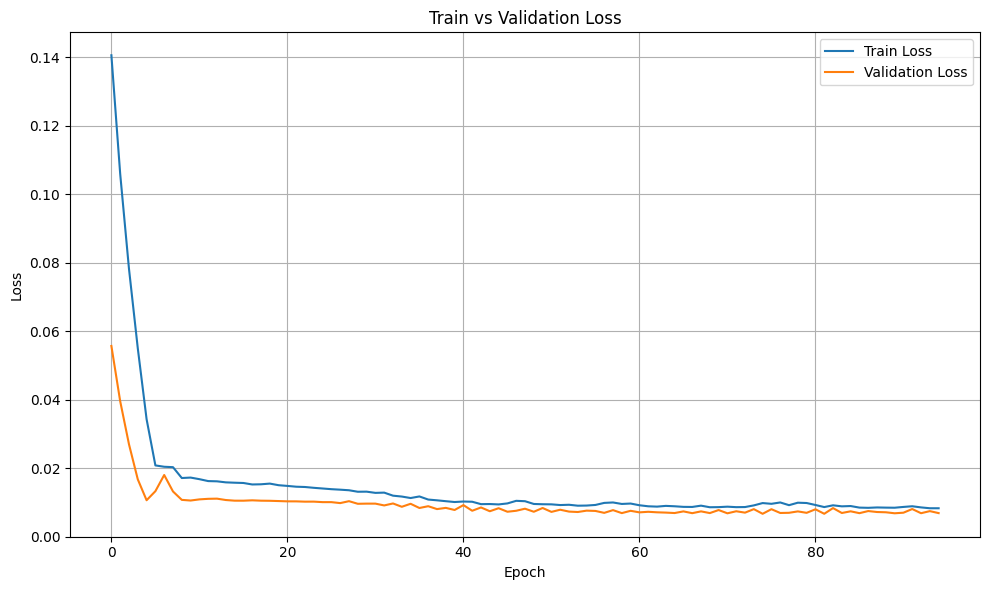

In [228]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import Callback, EarlyStopping
from sklearn.preprocessing import MinMaxScaler

# Prepare the data
time_series = wide_data[['Alkoholunfälle']]

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(time_series)

# Create lag-based input-output pairs
def create_lagged_data(data, look_back=12):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i + look_back])
        y.append(data[i + look_back])
    return np.array(X), np.array(y)

look_back = 12  # Use past 12 months to predict the next
X, y = create_lagged_data(scaled_data, look_back)

# Split into training and validation sets (80% train, 20% validation)
train_size = int(len(X) * 0.8)
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

# Reshape input to [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Custom Callback to Log Training Process
class LogToFileCallback(Callback):
    def __init__(self, log_file):
        self.log_file = log_file
        self.train_losses = []
        self.val_losses = []

    def on_epoch_end(self, epoch, logs=None):
        train_loss = logs.get('loss')
        val_loss = logs.get('val_loss')
        self.train_losses.append(train_loss)
        self.val_losses.append(val_loss)

        with open(self.log_file, 'a') as f:
            f.write(f"Epoch {epoch + 1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}\n")

# Log file for training process
log_file = 'log.txt'
open(log_file, 'w').close()  # Clear the log file before starting
log_callback = LogToFileCallback(log_file)

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    min_delta=1e-6
)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=0,  # Suppress console output
    callbacks=[log_callback, early_stopping]
)

# Plot the Train and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(log_callback.train_losses, label='Train Loss')
plt.plot(log_callback.val_losses, label='Validation Loss')
plt.title('Train vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Validation MSE: 62.4598


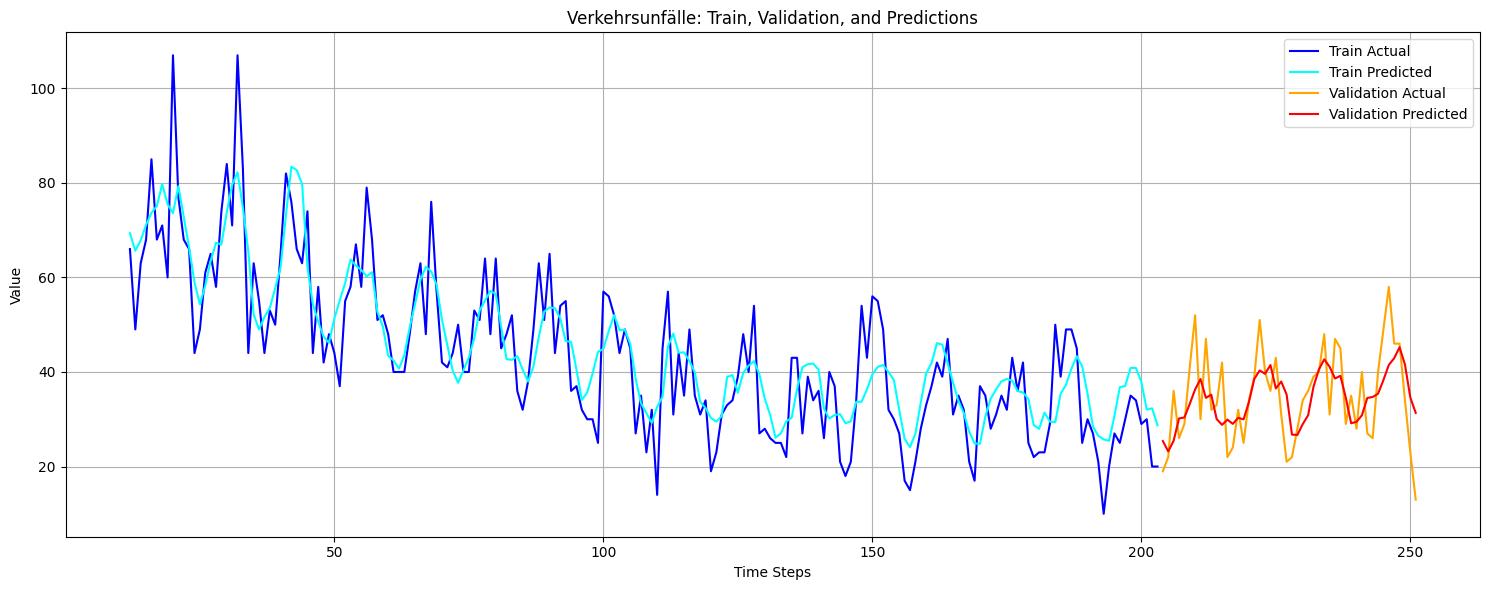

In [231]:
# Generate Predictions

# Predict on training data
train_predictions = model.predict(X_train, verbose=0)
train_predictions = scaler.inverse_transform(train_predictions)  # Convert back to original scale
y_train_original = scaler.inverse_transform(y_train)

# Predict on validation data
val_predictions = model.predict(X_val, verbose=0)
val_predictions = scaler.inverse_transform(val_predictions)  # Convert back to original scale
y_val_original = scaler.inverse_transform(y_val)

# Calculate Validation MSE
val_mse = mean_squared_error(y_val_original, val_predictions)
print(f'Validation MSE: {val_mse:.4f}')

# Plot Train, Validation, and Predictions
plt.figure(figsize=(15, 6))

# Plot training data and predictions
train_index = range(look_back, len(train_predictions) + look_back)
plt.plot(train_index, y_train_original, label='Train Actual', color='blue')
plt.plot(train_index, train_predictions, label='Train Predicted', color='cyan')

# Plot validation data and predictions
val_index = range(len(train_predictions) + look_back, \
    len(train_predictions) + len(val_predictions) + look_back)
plt.plot(val_index, y_val_original, label='Validation Actual', color='orange')
plt.plot(val_index, val_predictions, label='Validation Predicted', color='red')

# Add labels and legend
plt.title(f'{category}: Train, Validation, and Predictions')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()